<a href="https://colab.research.google.com/github/JuanArmas/BigDataSNS/blob/main/Practica_iterpretacion_vinos_JuanArmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Autor:
Juan Airam Armas Alemán

#Github:
https://github.com/JuanArmas/BigDataSNS/blob/main/Proyecto_SNS_JuanArmasAleman.ipynb

In [1]:
#Importar librerías y módulos

import io
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.externals
import matplotlib.pyplot as plt
#===============================#
from sklearn import tree
from sklearn.svm import SVC
from google.colab import files
from sklearn.tree import plot_tree,DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, KFold,cross_val_score #,cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error,log_loss
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier


# import math
# from sklearn.datasets import make_regression
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn import datasets,neighbors
# from sklearn.calibration import CalibratedClassifierCV


##Carga y normalización de datos:


#### Cargamos datos desde repo local e indicamos con codificación utf-8, que cree el dataframe y que separe por ";"

In [2]:
def upload_files ():
  #Lee el archivo desde local
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df_winequality = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), sep=';')
    # df_winequality = pd.read_csv(io.StringIO(uploaded[fn].decode('ISO-8859-1')), sep=';')
    return df_winequality

In [3]:
df_winequality = upload_files()
df_winequality

Saving winequality-white.csv to winequality-white (1).csv
User uploaded file "winequality-white (1).csv" with length 264426 bytes


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [4]:
print(df_winequality.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


#----Usando colab y recursos mios anteriores para comparar resultados----

##Usando herramientas: Matriz de correlación

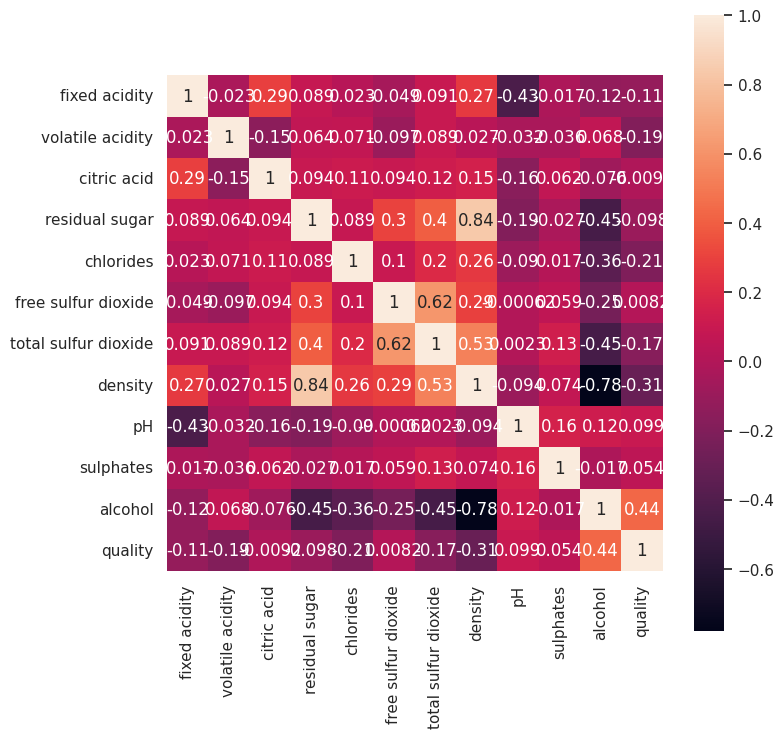

In [5]:
sns.set()
plt.figure(figsize=(8,8))  # Tamaño personalizado de la figura
sns.heatmap(df_winequality.corr(), square=True, annot=True)
plt.show()

In [6]:
#revisar si debo pasarle toda las caracteristicas a este array.
name_features_winequality = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
# name_features_winequality = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
#        'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','quality',
#        'pH', 'sulphates', 'alcohol']
X_winequality = df_winequality[name_features_winequality]
y_winequality = df_winequality['quality']

Generamos los conjuntos de datos tanto para entrenamiento como para test.

Una vez generados, volvemos a partir el conjuto de entrenamiento para sacar el conjunto de validación resenteando previamente los índices para evitar futuros conflictos

In [7]:
# Dividir los datos en conjunto de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X_winequality, y_winequality, test_size=0.3, random_state=42)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Convertir a arreglos numpy
X_train_ar = X_train.to_numpy()
y_train_ar = y_train.to_numpy().ravel()
X_val_ar = X_val.to_numpy()
X_test_ar = X_test.to_numpy()


##Usando herramientas: SelectKbest


In [8]:
selector = SelectKBest(f_classif, k=4)
# Ajustar el selector con los datos de entrenamiento
selector.fit(X_train_ar, y_train_ar)
# Obtener características seleccionadas y transformar conjuntos de entrenamiento/validación/prueba
char_selected = selector.get_feature_names_out(name_features_winequality)
X_train_selected = selector.transform(X_train_ar)
X_val_selected = selector.transform(X_val_ar)
X_test_selected = selector.transform(X_test_ar)

char_selected

array(['volatile acidity', 'total sulfur dioxide', 'density', 'alcohol'],
      dtype=object)

#Usando herramientas: RFE

Cuando se evalúa el modelo con RFE (Eliminación Recursiva de Características), se coteja el peso de cada característica con el conjunto al que pertenece (hiperplanos generados por SVM), y cuanto mayor sea su peso en ese conjunto, más relevante será, por lo que acabará siendo candidata a ser seleccionada, por contra, cuanto menos peso tenga en su conjunto de características, más probabilidades tendrá para ser eliminada.

In [17]:
# Selección Recursiva de Características (RFE)
# Entrena el modelo con todas las características, evalúa la importancia de
# cada característica y elimina iterativamente la menos importante.
# Entrena un clasificador SVM utilizando RFE para la selección de características
# y calcula la precisión en los conjuntos de validación y prueba.
# Para ello, mide la importancia de cada característica según cómo contribuye a la
# separación de las clases en el conjunto de datos, después, se evalúa
# el rendimiento del modelo utilizando solo las características seleccionadas en un
# conjunto de validación o prueba independiente.


# Se define el clasificador SVM
svm_classifier = SVC(kernel="linear")

# Se Inicializa y entrena RFE
rfe = RFE(estimator=svm_classifier, n_features_to_select=4, step=1)
rfe.fit(X_train_ar, y_train_ar)

# se obtienen las columnas seleccionadas
selected_columns = X_train.columns[rfe.support_]

# se aplica la selección de características a los conjuntos de entrenamiento, validación y prueba
X_train_selected = rfe.transform(X_train_ar)
X_val_selected = rfe.transform(X_val_ar)
X_test_selected = rfe.transform(X_test_ar)

# Se vuelve a entrenar el modelo SVM con las características seleccionadas
svm_classifier.fit(X_train_selected, y_train_ar)

# Predecir en los conjuntos de validación y prueba
y_val_pred = svm_classifier.predict(X_val_selected)
y_test_pred = svm_classifier.predict(X_test_selected)

# Calcular la precisión en los conjuntos de validación y prueba
accuracy_val = accuracy_score(y_val, y_val_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f'Precisión en el conjunto de validación: {accuracy_val}')
print(f'Precisión en el conjunto de prueba: {accuracy_test}')

# Imprimir las características seleccionadas
print('Características seleccionadas:', selected_columns)


Precisión en el conjunto de validación: 0.514585764294049
Precisión en el conjunto de prueba: 0.5129251700680272
Características seleccionadas: Index(['volatile acidity', 'pH', 'sulphates', 'alcohol'], dtype='object')


#ARBOLES:

#Arbol de decisión

In [9]:
#revisar si debo pasarle toda las caracteristicas a este array.
name_features_winequality2 = ['volatile acidity', 'pH', 'sulphates', 'alcohol']
df_winequality2 = df_winequality[['volatile acidity', 'pH', 'sulphates', 'alcohol', 'quality']]

X_winequality2 = df_winequality2
y_winequality2 = df_winequality['quality']

Profundidad del árbol: 1, Precisión media: 0.4401400233372229, Desviación estándar: 0.016267567717940207
Profundidad del árbol: 2, Precisión media: 0.5091015169194865, Desviación estándar: 0.0040773407723818265
Profundidad del árbol: 3, Precisión media: 0.51073512252042, Desviación estándar: 0.006518776066960765
Profundidad del árbol: 4, Precisión media: 0.5199533255542591, Desviación estándar: 0.00682788277168161
Profundidad del árbol: 5, Precisión media: 0.5107351225204201, Desviación estándar: 0.010437375623716846
Profundidad del árbol: 6, Precisión media: 0.5037339556592766, Desviación estándar: 0.014262938544781582
Profundidad del árbol: 7, Precisión media: 0.4978996499416569, Desviación estándar: 0.01217176568311345
Profundidad del árbol: 8, Precisión media: 0.49684947491248543, Desviación estándar: 0.013271474640012064
Profundidad del árbol: 9, Precisión media: 0.4943990665110851, Desviación estándar: 0.009791209659649082
Profundidad del árbol: 10, Precisión media: 0.49451575262

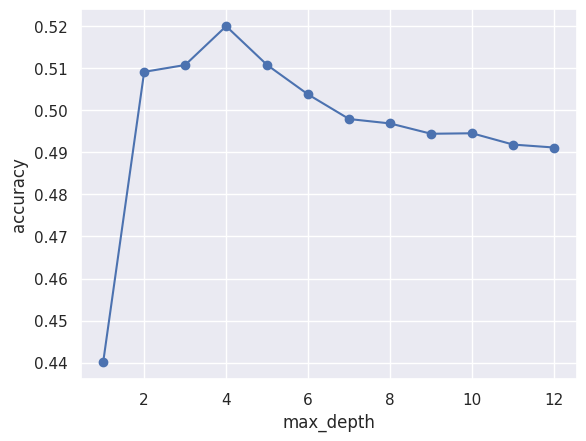

In [10]:
# Es necesario resetear los índices para que no de error CV
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_winequality2, y_winequality2, test_size=0.3, random_state=42)

X_train2.reset_index(drop=True, inplace=True)
y_train2.reset_index(drop=True, inplace=True)

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.25, random_state=42)


cv = KFold(n_splits = 10, shuffle = False) #
accuracies = list()
# max_attributes = len(list(df_winequality))
# depth_range = range(1, max_attributes * 3)
depth_range = range(1, len(name_features_winequality2) * 3 + 1)

#
# X_train, X_test, y_train, y_test = train_test_split(X_winequality, y_winequality, test_size=0.3, random_state=42)
#


# from 1 to number of features * 2



for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split = 65,
                                             min_samples_leaf = 20,
                                             max_depth = depth)
    for train_fold, test_fold in cv.split(X_train2):
        f_train = X_train2.iloc[train_fold]
        f_test = X_train2.iloc[test_fold]

        model = tree_model.fit( X = f_train.drop(['quality'], axis=1),
                               y = f_train['quality'])

        #test_acc = model.score(X = f_test.drop(['quality'], axis=1),
        #                        y = f_test['quality'])
        test_acc = model.score(X = X_val2.drop(['quality'], axis=1),
                                y = X_val2['quality'])

        fold_accuracy.append(test_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    print(f"Profundidad del árbol: {depth}, Precisión media: {avg}, Desviación estándar: {np.std(fold_accuracy)}")

import matplotlib.pyplot as plt
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

# Matriz de confusión

In [11]:
X_train2.reset_index(drop=True, inplace=True)
y_train2.reset_index(drop=True, inplace=True)

#Constructor/Parametrization
clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 65,
                                  min_samples_leaf = 20, max_depth = 4)
# fit: training the model
clf.fit(X_train2[name_features_winequality2], y_train2) # Construcción del modelo

# prediction/test
preds = clf.predict(X_test2[name_features_winequality2])

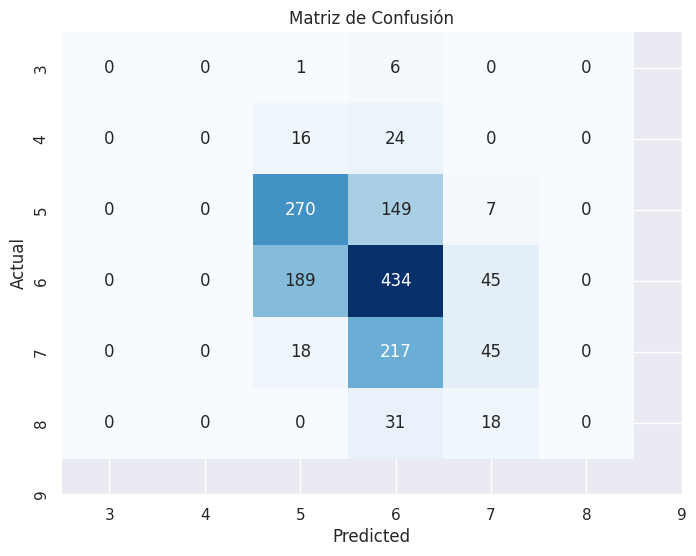

In [12]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, preds)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

----

 # En algunos casos, reducir el conjunto de características puede ayudar a evitar el sobreajuste y mejorar la interpretabilidad del modelo. En otros casos, utilizar todas las características puede capturar mejor la complejidad del problema.

----

# Random forest

Mejor número de árboles (n_estimators): 21
Precisión media con el mejor número de árboles: 0.6356455491477091


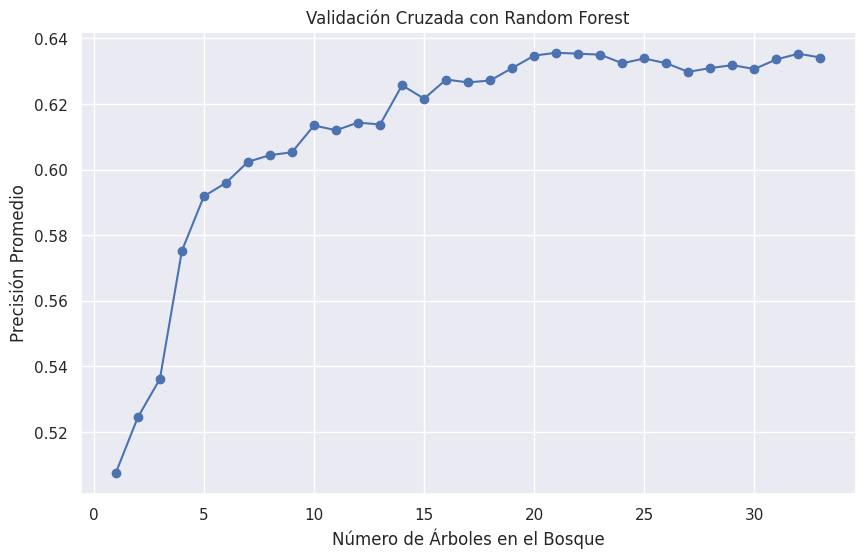

In [13]:
# Concatenar los conjuntos de entrenamiento y validación
X_train_val_ar = np.vstack((X_train_ar, X_val_ar))
y_train_val_ar = np.concatenate((y_train_ar, y_val))

# Número de árboles en el bosque
# n_estimators_values = [10, 50, 100, 200]
n_estimators_values = range(1, len(name_features_winequality) * 3 + 1)

# Almacenar resultados de la validación cruzada
cv_results = []

# Realizar validación cruzada con diferentes números de árboles
for n_estimators in n_estimators_values:
    # Inicializar Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Realizar validación cruzada con KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_classifier, X_train_val_ar, y_train_val_ar, cv=kfold, scoring='accuracy')

    # Almacenar resultados
    cv_results.append(np.mean(cv_scores))

best_n_estimators = n_estimators_values[np.argmax(cv_results)]
best_accuracy = np.max(cv_results)

# Imprimir resultados
print(f'Mejor número de árboles (n_estimators): {best_n_estimators}')
print(f'Precisión media con el mejor número de árboles: {best_accuracy}')

# Visualizar resultados con matplotlib
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, cv_results, marker='o')
plt.title('Validación Cruzada con Random Forest')
plt.xlabel('Número de Árboles en el Bosque')
plt.ylabel('Precisión Promedio')
plt.grid(True)
plt.show()

#Matriz de confusión

Mejor número de árboles (n_estimators): 21
Precisión media con el mejor número de árboles: 0.6356455491477091
Precisión en el conjunto de prueba: 0.6673469387755102


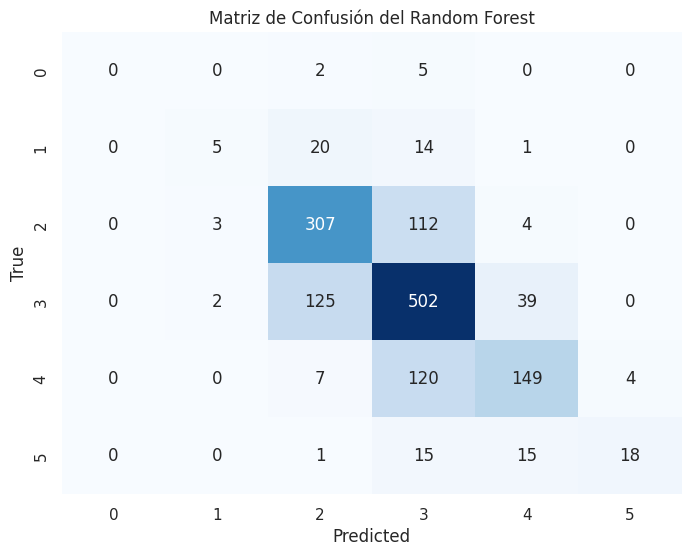

In [14]:
# Imprimir de nuevo los resultados de la validación cruzada como referencia
print(f'Mejor número de árboles (n_estimators): {best_n_estimators}')
print(f'Precisión media con el mejor número de árboles: {np.max(cv_results)}')

# Entrenar el modelo Random Forest con el mejor número de árboles
rf_classifier.fit(X_train_val_ar, y_train_val_ar)

# Predecir en el conjunto de prueba
y_test_pred = rf_classifier.predict(X_test_ar)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calcular la precisión en el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Precisión en el conjunto de prueba: {accuracy_test}')

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión del Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




#Boosted Forest (usando algoritmo Gradient Boosting Trees)

Precisión media con Boosted Trees: 0.5921844608542062


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


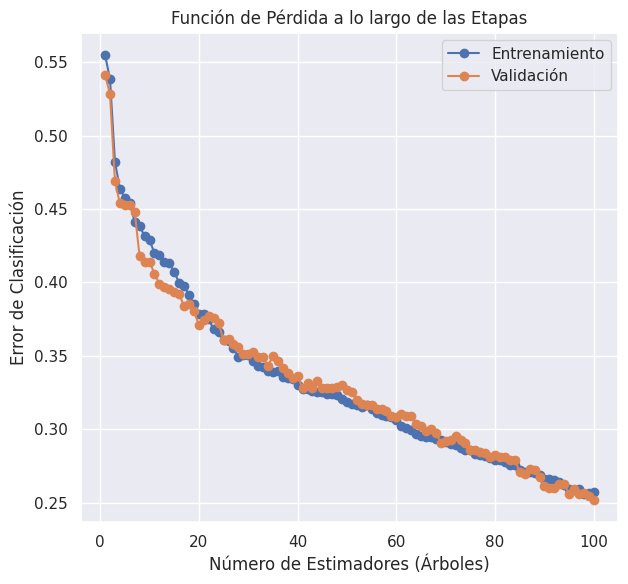

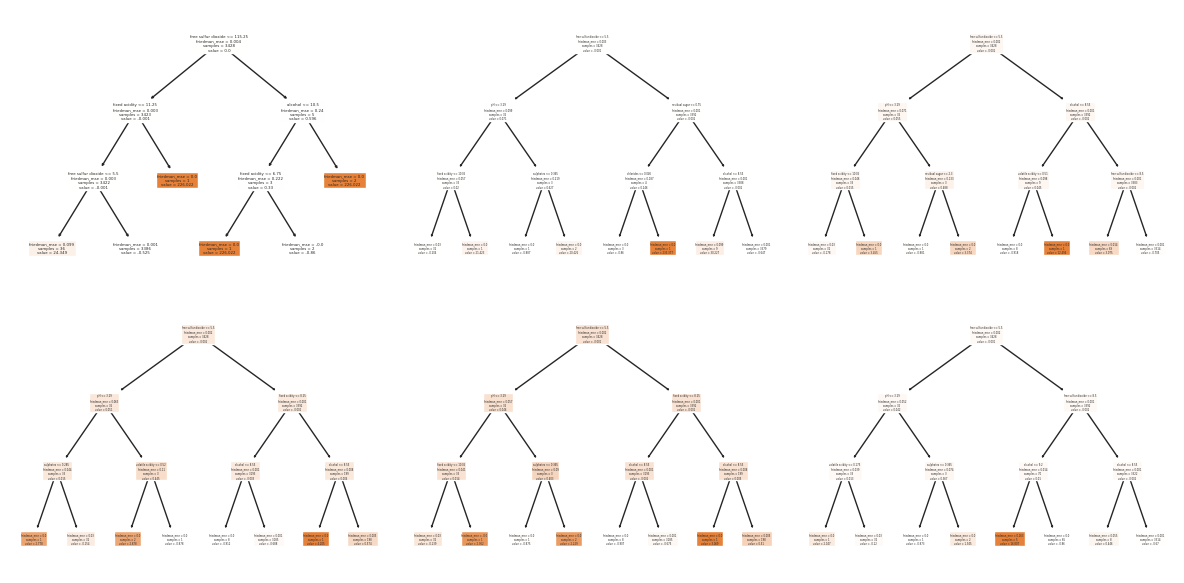

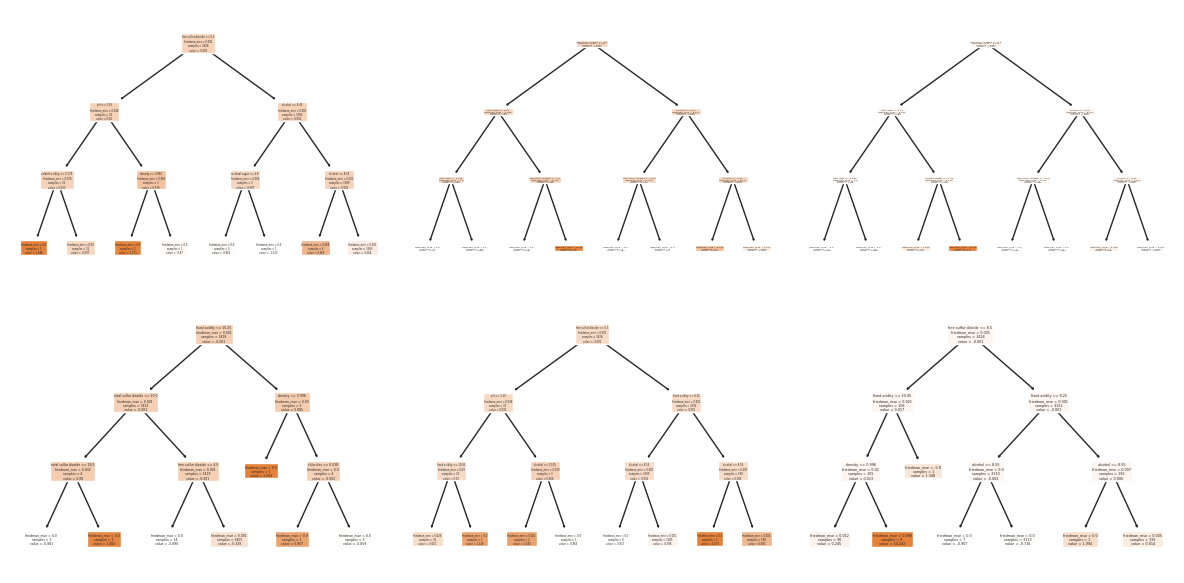

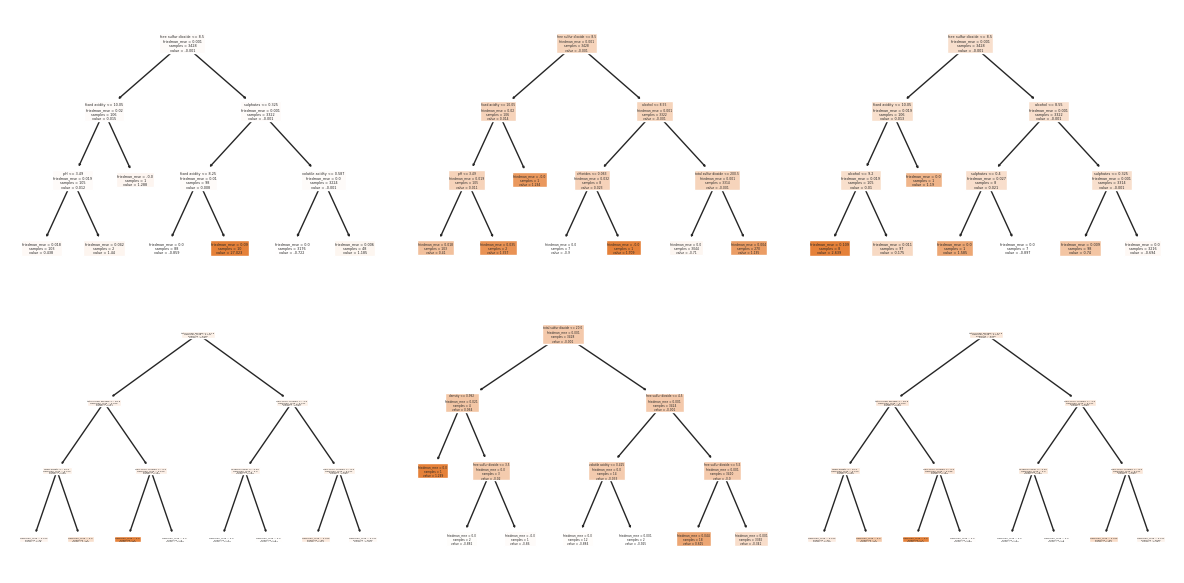

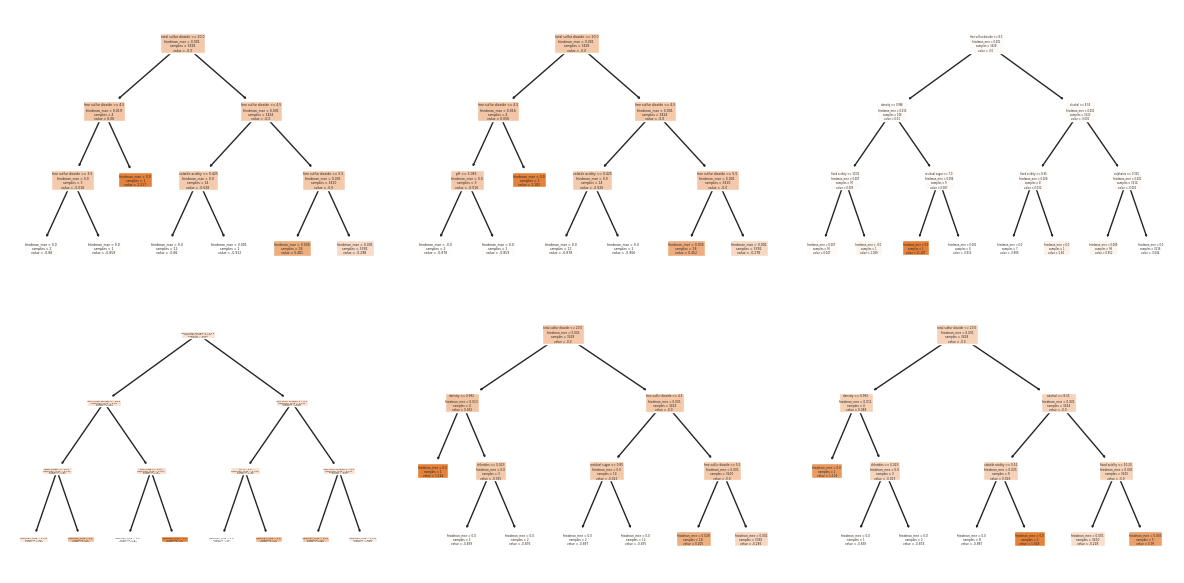

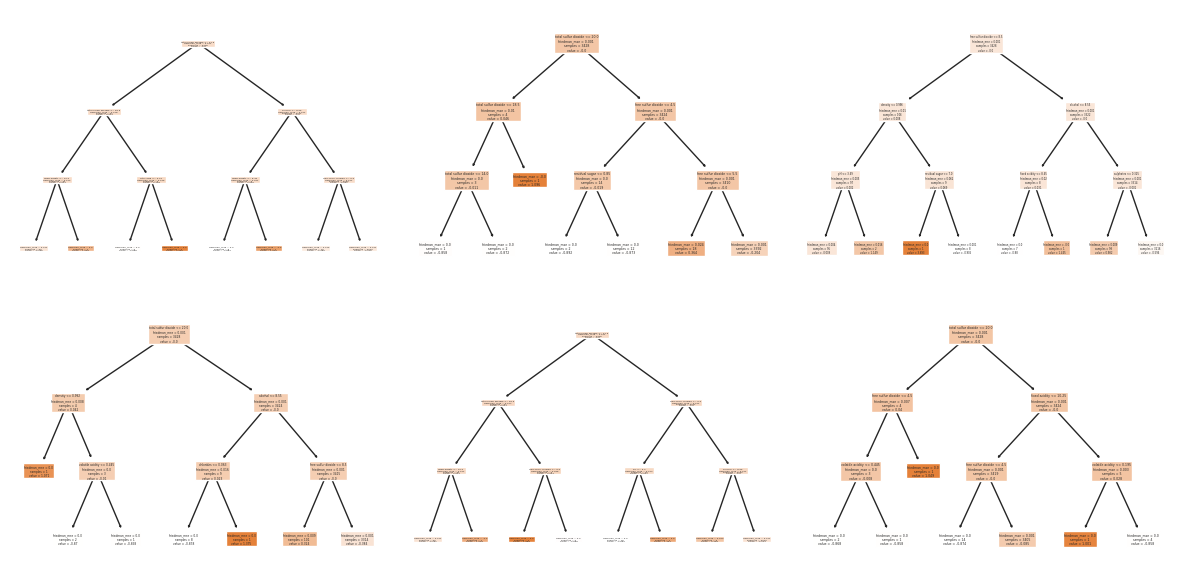

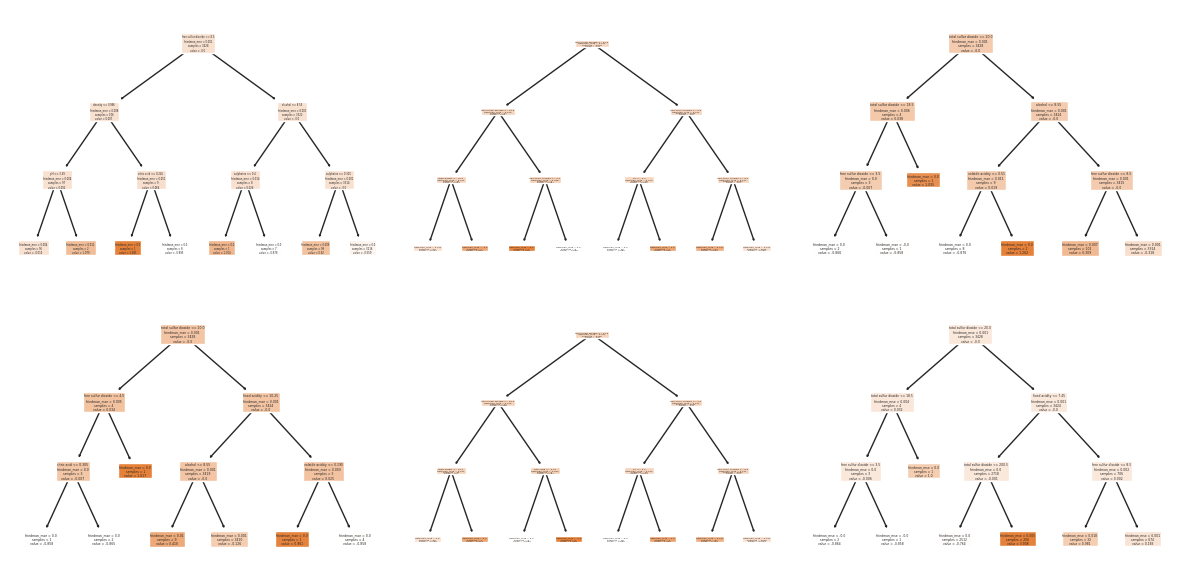

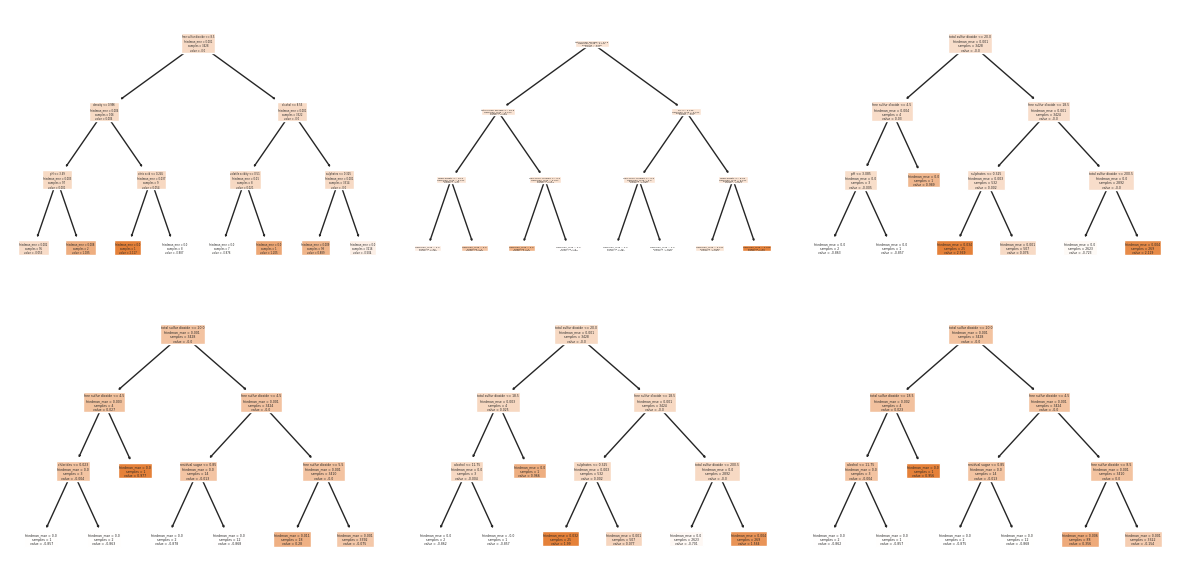

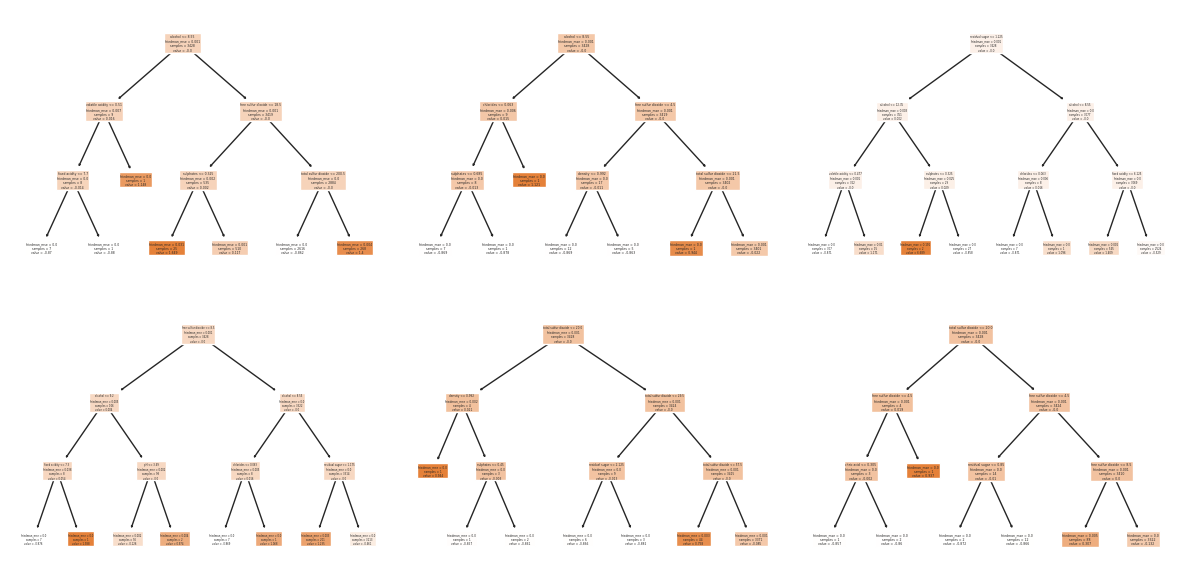

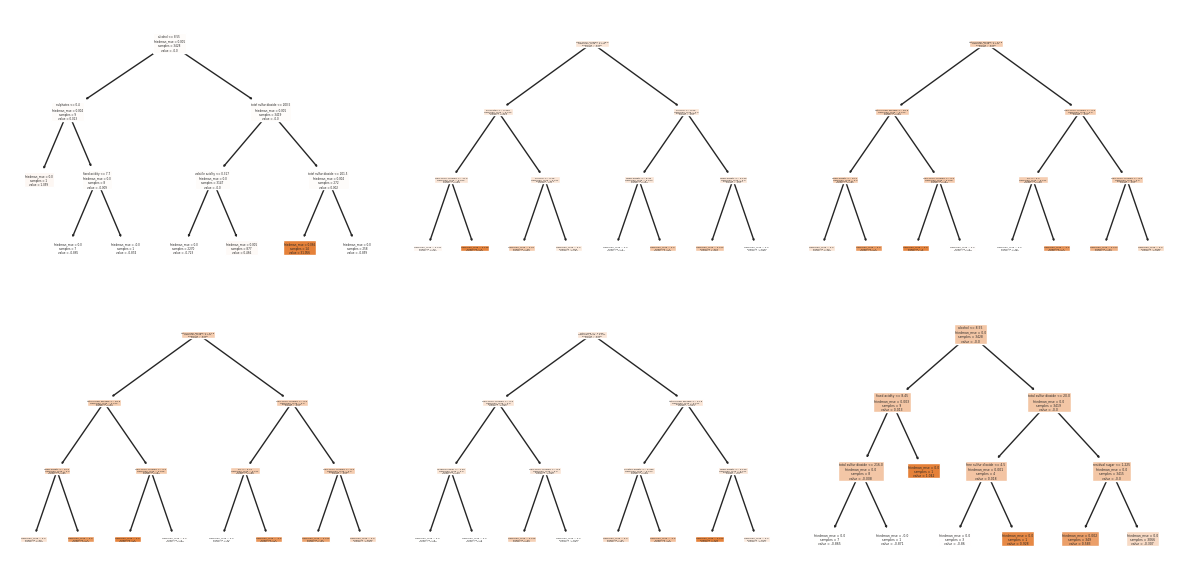

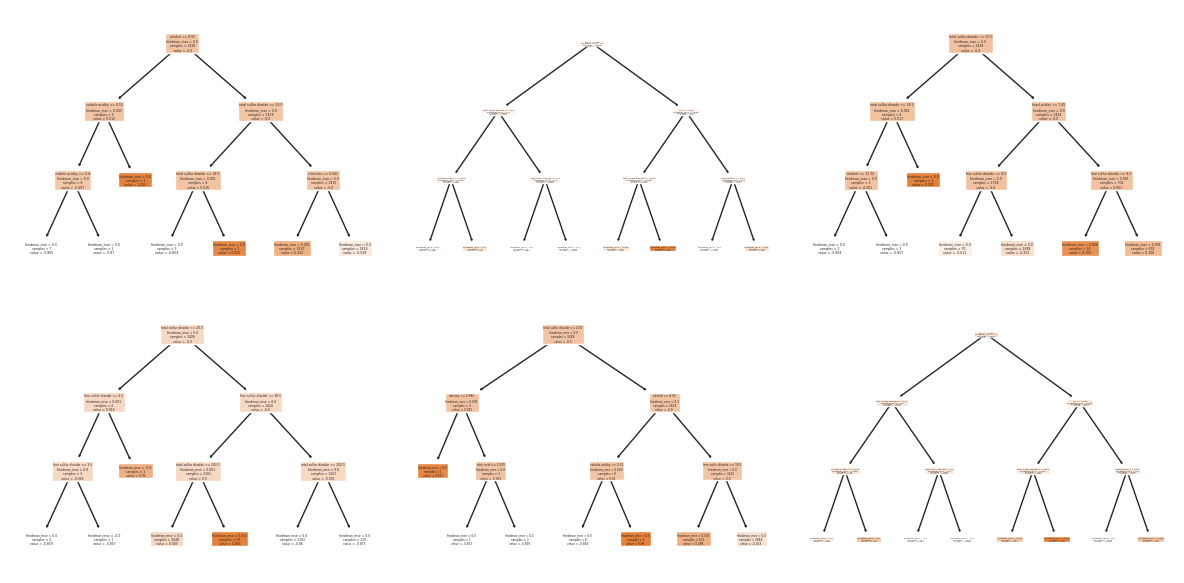

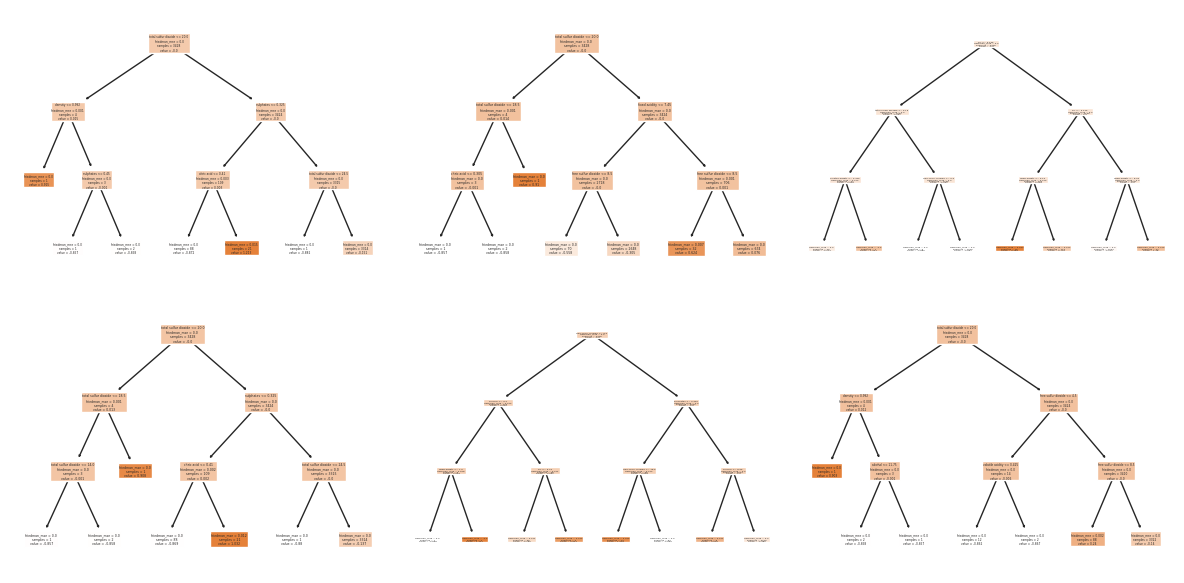

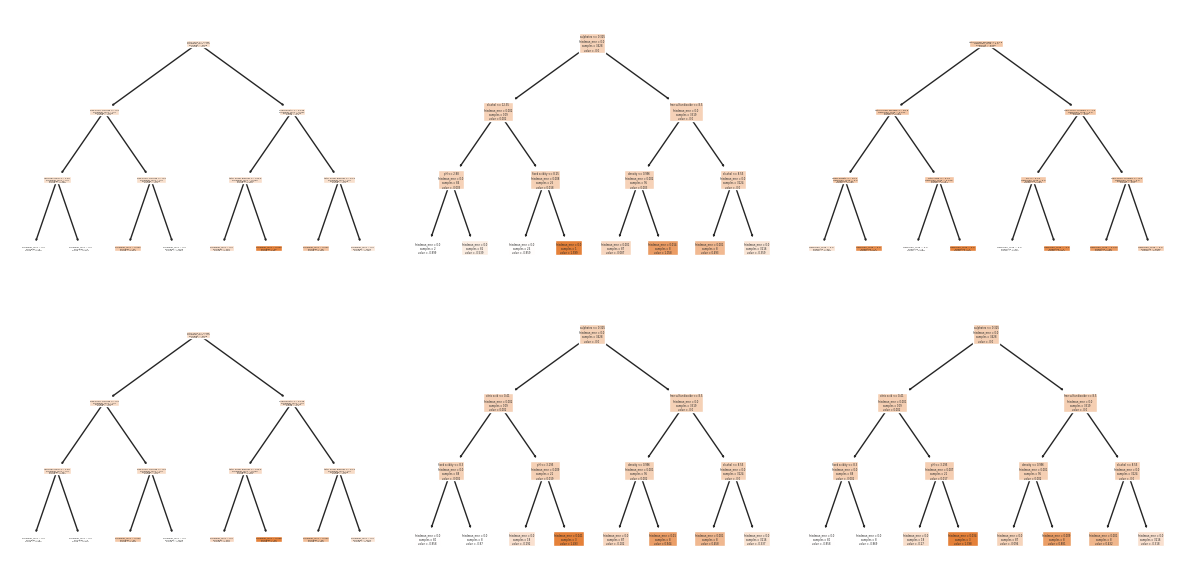

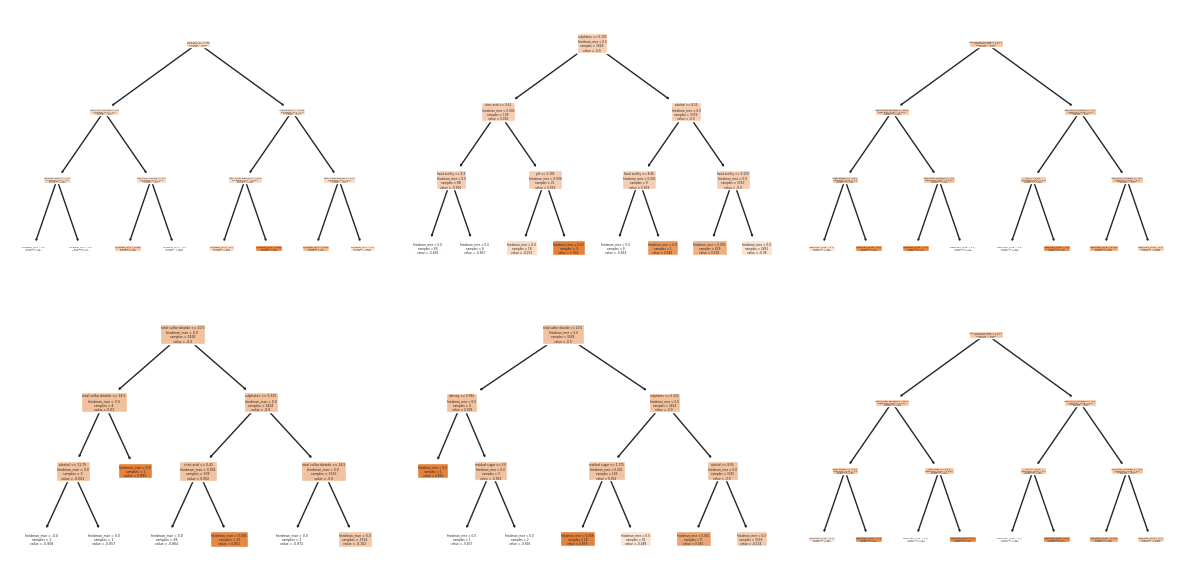

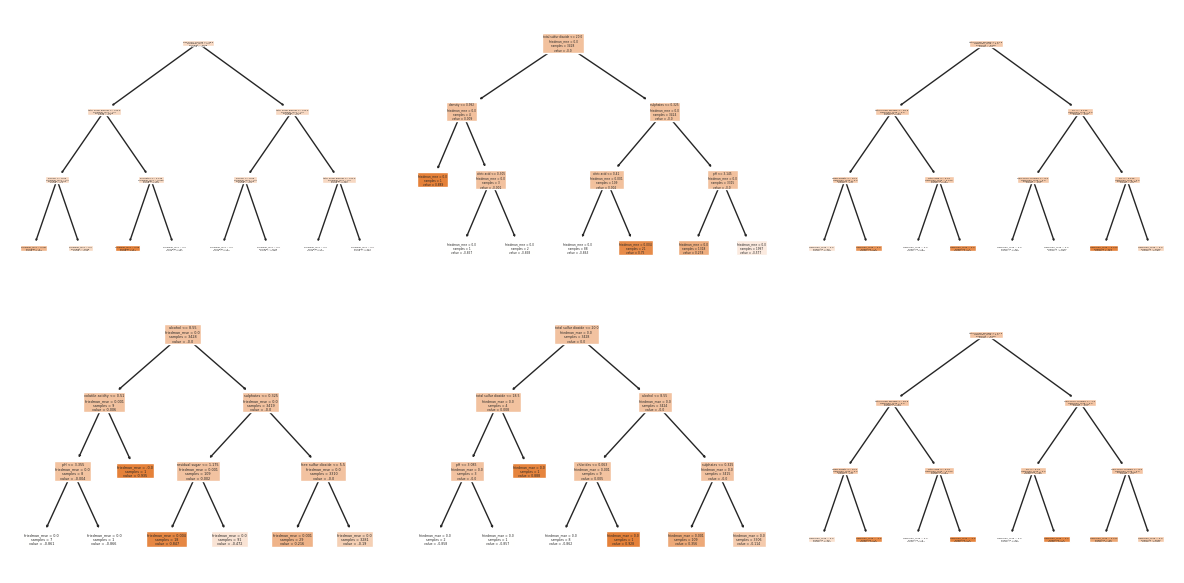

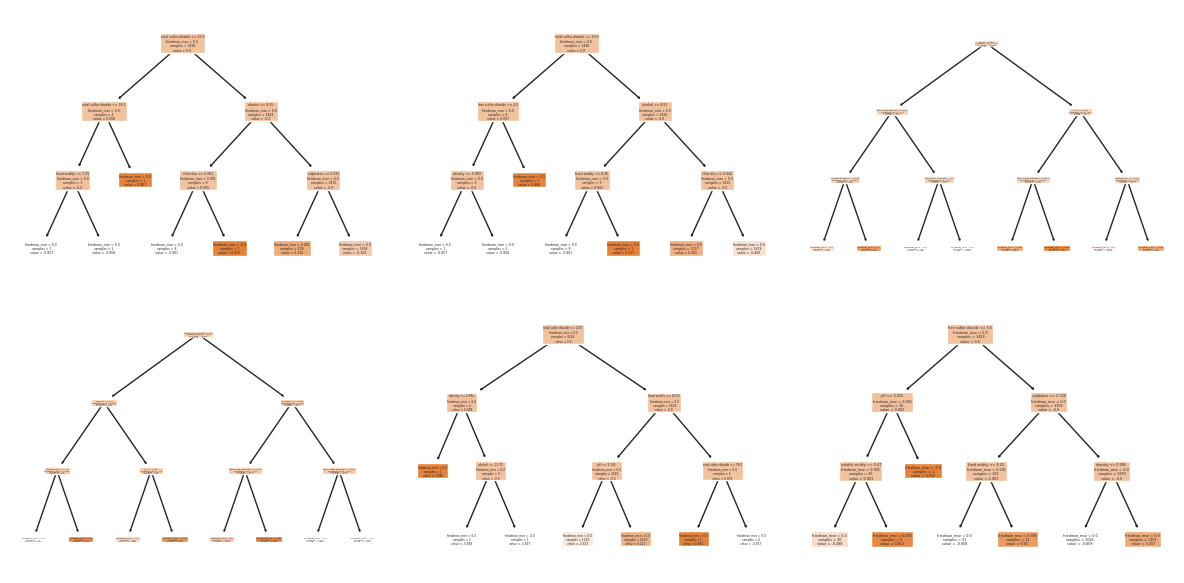

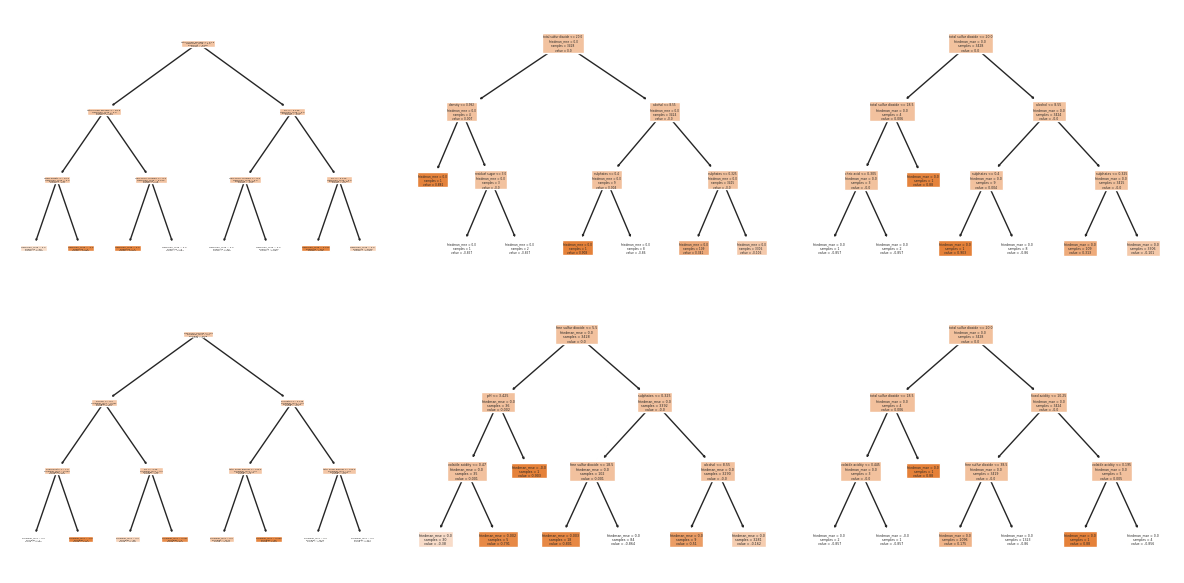

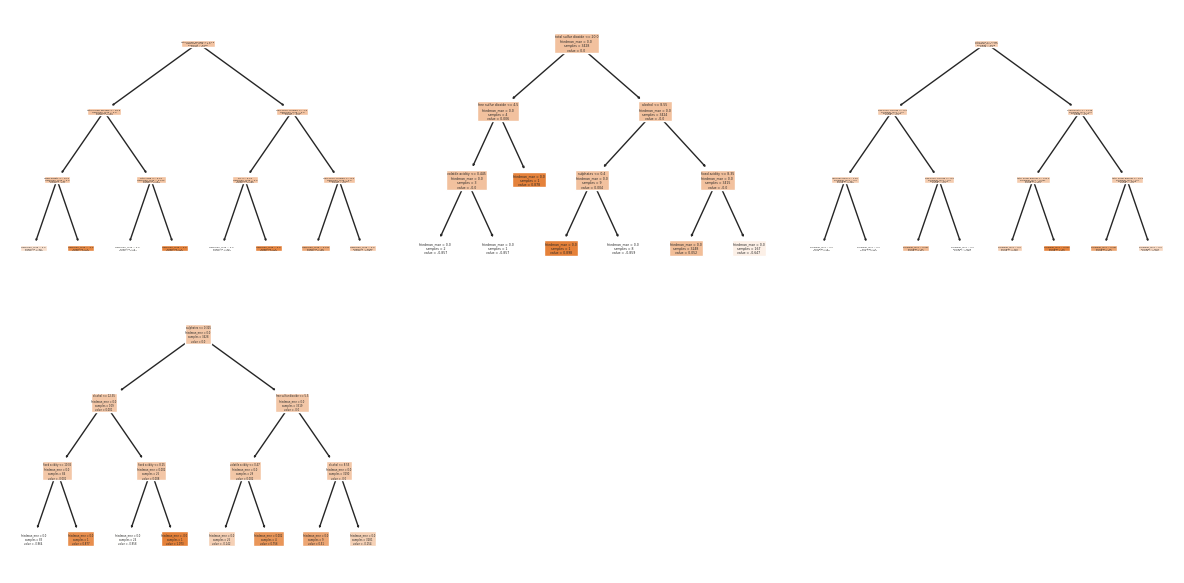

<Figure size 1200x600 with 0 Axes>

In [15]:
# Dividimos de nuevo los datos en conjunto de entrenamiento, validación y prueba originales
X_train, X_test, y_train, y_test = train_test_split(X_winequality, y_winequality, test_size=0.3, random_state=42)
# Dividir de nuevo el conjunto de entrenamiento en entrenamiento y validación originales
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Convertir a arreglos numpy
X_train_ar = X_train.to_numpy()
y_train_ar = y_train.to_numpy().ravel()
X_val_ar = X_val.to_numpy()
X_test_ar = X_test.to_numpy()

# Concatenamos los conjuntos de entrenamiento y validación
X_train_val_ar2 = np.vstack((X_train_ar, X_val_ar))
y_train_val_ar2 = np.concatenate((y_train_ar, y_val))

# Número de estimadores (árboles) en el bosque
n_estimators = 100


# Almacenamos resultados de la validación cruzada
cv_results = []

# Realizamos validación cruzada con Boosted Trees
boosted_classifier2 = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

# Utilizamos KFold para validación cruzada
kfold2 = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores2 = cross_val_score(boosted_classifier2, X_train_val_ar2, y_train_val_ar2, cv=kfold2, scoring='accuracy')

# Almacenamos los resultados
cv_results.append(np.mean(cv_scores2))

# Imprimimos los resultados de la validación cruzada
print(f'Precisión media con Boosted Trees: {np.mean(cv_scores2)}')

# Ajustamos el modelo Boosted Trees en el conjunto de entrenamiento y validación
boosted_classifier2.fit(X_train_val_ar2, y_train_val_ar2)

# Obtenemos errores de clasificación en cada etapa
train_errors = []
val_errors = []

for i, y_pred_train in enumerate(boosted_classifier2.staged_predict(X_train)):
    train_errors.append(1 - accuracy_score(y_train, y_pred_train))

for i, y_pred_val in enumerate(boosted_classifier2.staged_predict(X_val)):
    val_errors.append(1 - accuracy_score(y_val, y_pred_val))

# Visualizamos las funciones de pérdida a lo largo de las etapas
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(train_errors) + 1), train_errors, label='Entrenamiento', marker='o')
plt.plot(np.arange(1, len(val_errors) + 1), val_errors, label='Validación', marker='o')
plt.xlabel('Número de Estimadores (Árboles)')
plt.ylabel('Error de Clasificación')
plt.title('Función de Pérdida a lo largo de las Etapas')
plt.legend()
plt.tight_layout()
plt.show()


# Obtenemos el número de árboles
num_trees = len(boosted_classifier2.estimators_)

# Definimos la disposición de los subplots
rows = 2
cols = 3

# Aquí se muestran los distintos árboles que se han ido generando en las iteraciones
plt.figure(figsize=(12, 6))
for i, tree in enumerate(boosted_classifier2.estimators_):
    plt.subplot(rows, cols, i % (rows * cols) + 1)
    plot_tree(tree[0], filled=True, feature_names=X_train.columns, class_names=['0', '1'])
    if (i + 1) % (rows * cols) == 0 or i == num_trees - 1:
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(12, 6))


#matriz de confusión

Precisión en el conjunto de prueba: 0.5857142857142857


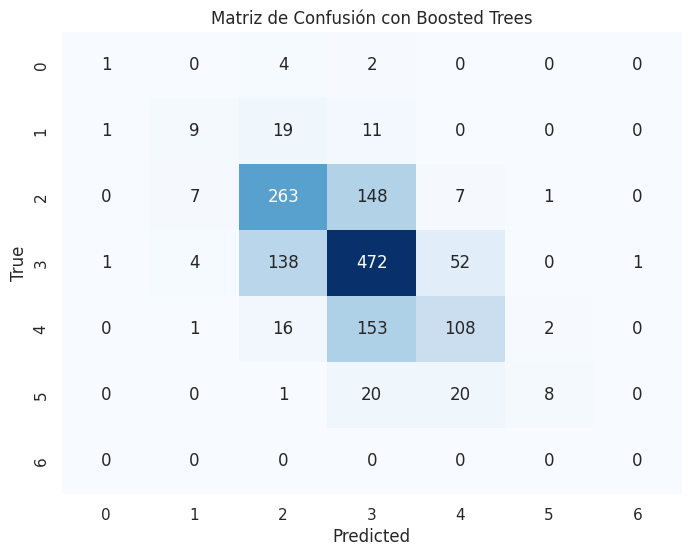

In [16]:
# Predecir en el conjunto de prueba
y_test_pred2 = boosted_classifier2.predict(X_test_ar)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred2)
# Calcular la precisión en el conjunto de prueba

accuracy_test = accuracy_score(y_test, y_test_pred2)
print(f'Precisión en el conjunto de prueba: {accuracy_test}')

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión con Boosted Trees')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



# Exportar Fichero

Usando Joblib

In [ ]:
#Exportar el fichero entrenado

# joblib.dump(rf_classifier,'RF_modelo_entrenado.pkl')
joblib.dump(boosted_classifier2,'boostedF_modelo_entrenado.pkl')

In [ ]:
# Cargar el modelo desde el archivo
boosted_classifier_entrenado = joblib.load('boostedF_modelo_entrenado.pkl')

# Hacer predicciones en el conjunto de prueba
y_pred = boosted_classifier_entrenado.predict(X_test)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

acc = (boosted_classifier_entrenado.score(X_test, y_test))*100

print("Precisión del modelo entrenado y descargado: {:.1f}%".format(acc))

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()
